In [1]:
import pandas as pd
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as ntx
import re
import altair as alt

# ref doc https://github.com/eliorc/node2ve and https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
from node2vec import Node2Vec 
from sklearn.model_selection import train_test_split
from music_utils import *
from tqdm.auto import tqdm  # import tqdm for progress bar
tqdm.pandas()

In [2]:
local = True
if local:
    DATA_PATH = '../Music_project/data/'
else:
    DATA_PATH = './data/'

In [3]:
def graph_largest_cc(nodes_df, plot_graph=False, write_graphml=None):   
    edge_list = [tuple(l[:2]) for l in nodes_df.values.tolist()]
    G = ntx.from_edgelist(edge_list)
    largest_cc = G.subgraph(max(ntx.connected_components(G), key=len))
    print(f'The largest connected component has {len(largest_cc.nodes)} nodes.')
    print(f'The largest connected component has {len(largest_cc.edges)} edges.')

    if plot_graph:
        fig, ax = plt.subplots(figsize=(15, 15))
        ntx.draw_networkx(largest_cc, with_labels=False, node_size = 20, ax = ax)
        plt.show()
    
    if write_graphml != None:
        ntx.write_graphml_lxml(G, write_graphml+'.graphml')
    return G, largest_cc

# Spotify 600k songs

In [4]:
spotify_600, artists_600 = read_spotify_600(DATA_PATH=DATA_PATH, read=False)

In order to keep only music, we will filter the songs based on the speechiness. Indeed, if a song is from an audio-book or so, it will have a high speechiness score. Hence, we will filter out songs that have a speechiness score that is higher than 0.7.

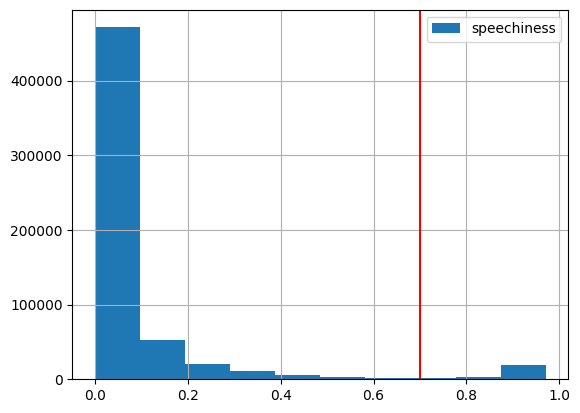

In [5]:
spotify_600["speechiness"].hist(legend = "Speechiness").axvline(x = 0.7, color = "red")

In [6]:
# Filter out non-music
n_non_music = sum(spotify_600["speechiness"] > 0.7)
print(f"We are deleting {n_non_music} songs from the dataframe")
spotify_600 = spotify_600[spotify_600["speechiness"] < 0.7]

#Nodes creation
feat_track_600 = spotify_600[(spotify_600.num_artists > 1)&(spotify_600.release_date.dt.year > 1999)].copy()
nodes_600 = nodes_featuring(feat_track_600, DATA_PATH=DATA_PATH, read=True, path='edge_list_600k_over1999.pkl')

#artists feature creation
artists_600_features = artists_features_creation(artists_600, spotify_600, DATA_PATH, read=True)

#Genres
genres = pd.DataFrame(artists_600_features.genres.explode().value_counts().reset_index()).dropna().rename(
    columns={'index':'genre','genres':'number_of_artists'}
)

We are deleting 22100 songs from the dataframe


In [20]:
edge_list = [tuple(l[:2]) for l in nodes_600.values.tolist()]
G = ntx.from_edgelist(edge_list)
largest_cc = G.subgraph(max(ntx.connected_components(G), key=len))
print(f'The largest connected component has {len(largest_cc.nodes)} nodes.')
print(f'The largest connected component has {len(largest_cc.edges)} edges.')

The largest connected component has 20500 nodes.
The largest connected component has 62429 edges.


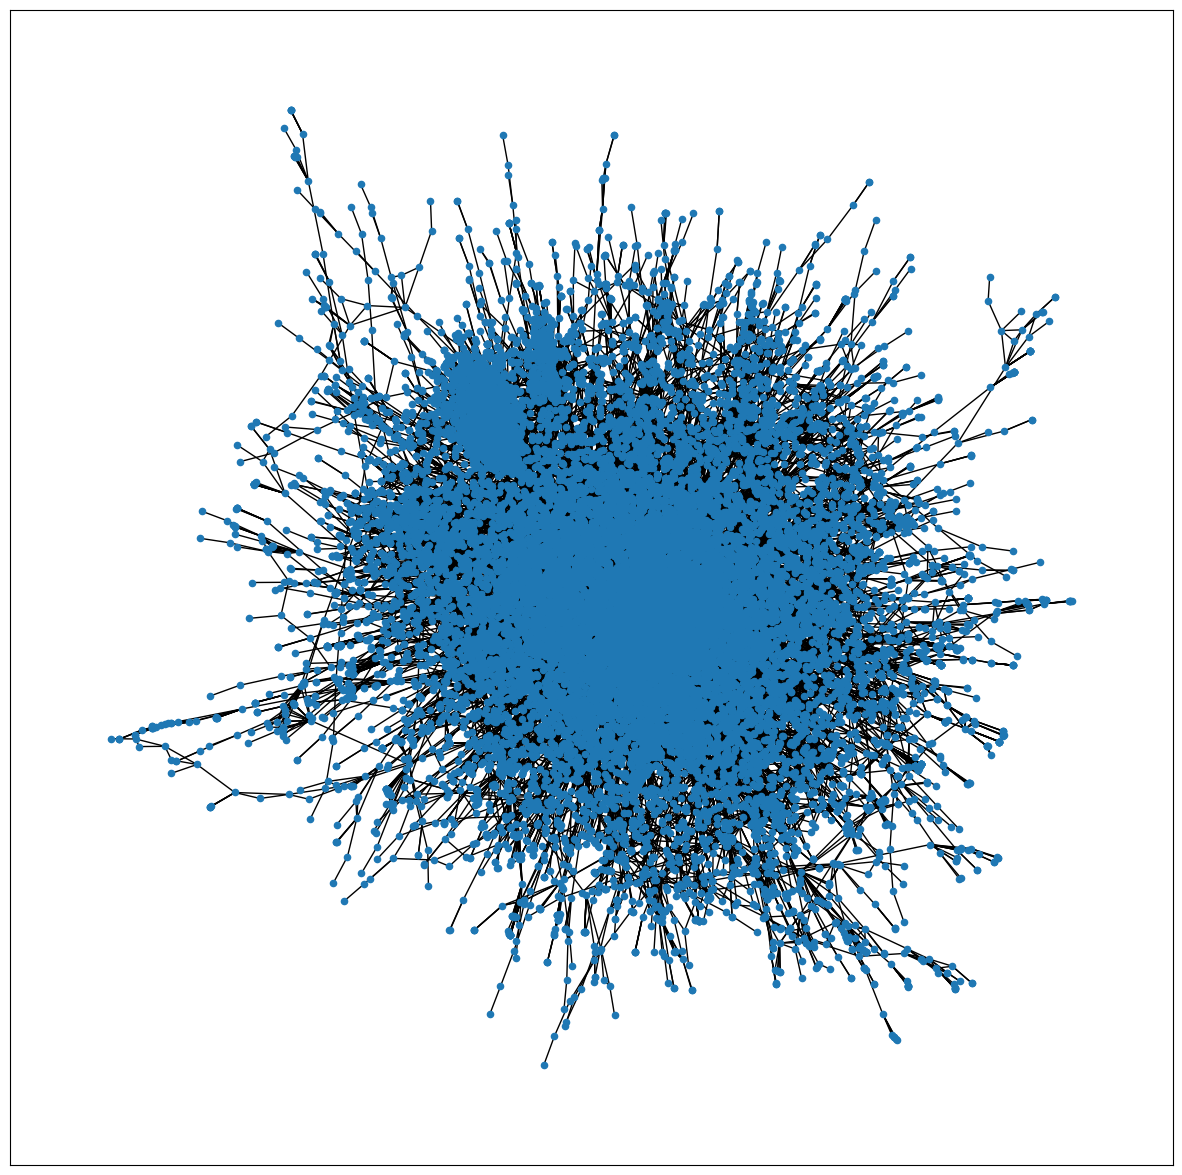

In [10]:
# didn't work on my local computer, but did work on colab, some issue with the installed networkx version
fig, ax = plt.subplots(figsize=(15, 15))
ntx.draw_networkx(largest_cc, with_labels=False, node_size = 20, ax = ax)

## Sub graph of french rap

In [ ]:
mask = artists_600_features['genres'].apply(lambda x: ('rap francais' in x) or ('french hip hop' in x))
# use the boolean mask to select the rows that contain 'rap francais' in the genres column
rap_francais_artists = artists_600_features[mask]
#the artists ids
french_rap_artist_ids = list(rap_francais_artists.index)

In [ ]:
#Nodes creation
# select rows where at least one element in the artist ids is in the french rapper list
french_rap_tracks = spotify_600[(spotify_600.num_artists > 1)].copy()
rap_mask = french_rap_tracks.id_artists.apply(lambda x: any(elem in french_rap_artist_ids for elem in x))
french_rap_tracks = french_rap_tracks[rap_mask]
# #every tracks where a french rapper is involved
nodes_french_rap = nodes_featuring(french_rap_tracks, DATA_PATH=DATA_PATH, read=False, path='edge_list_french_rap.pkl')

The largest connected component has 485 nodes.
The largest connected component has 1548 edges.


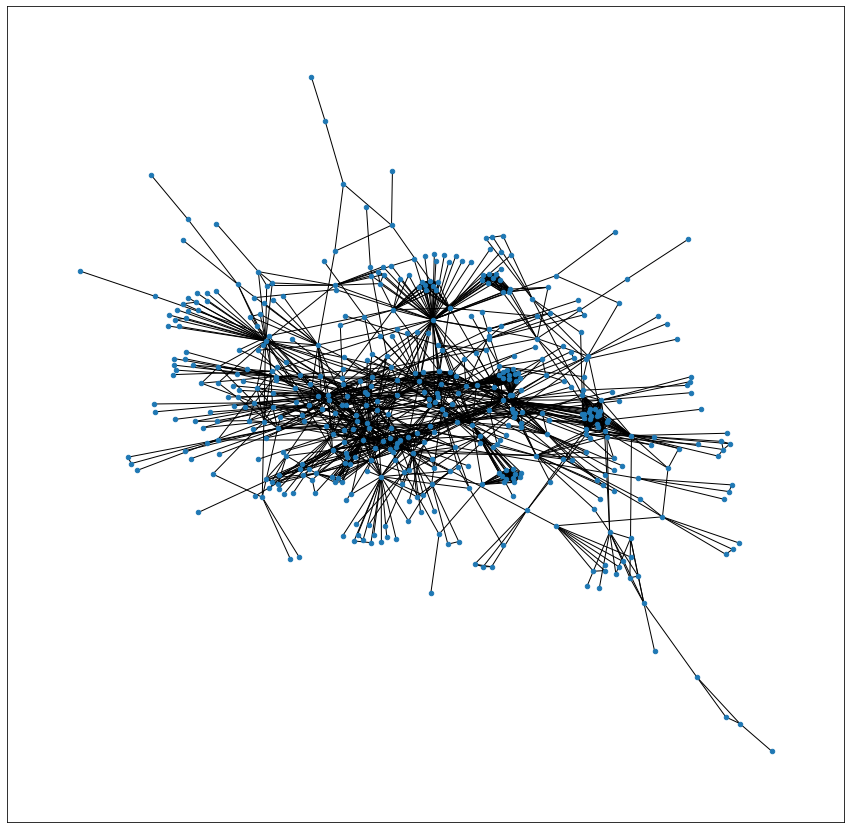

(<networkx.classes.graph.Graph at 0x7fe24c462580>,
 <networkx.classes.graph.Graph at 0x7fe255d43370>)

In [ ]:
graph_largest_cc(nodes_french_rap, plot_graph=True, write_graphml=DATA_PATH+'french_rap_G')

## Yearly graphs

In [4]:
spotify_600, artists_600 = read_spotify_600(DATA_PATH=DATA_PATH, read=True)

# Filter out non-music
n_non_music = sum(spotify_600["speechiness"] > 0.7)
print(f"We are deleting {n_non_music} songs from the dataframe")
spotify_600 = spotify_600[spotify_600["speechiness"] < 0.7]

We are deleting 22100 songs from the dataframe


In [5]:
songs_by_year, largest_cc_year = get_largest_cc_by_year(spotify_600, DATA_PATH, read = True, yearly_dir_name="yearly_600k")

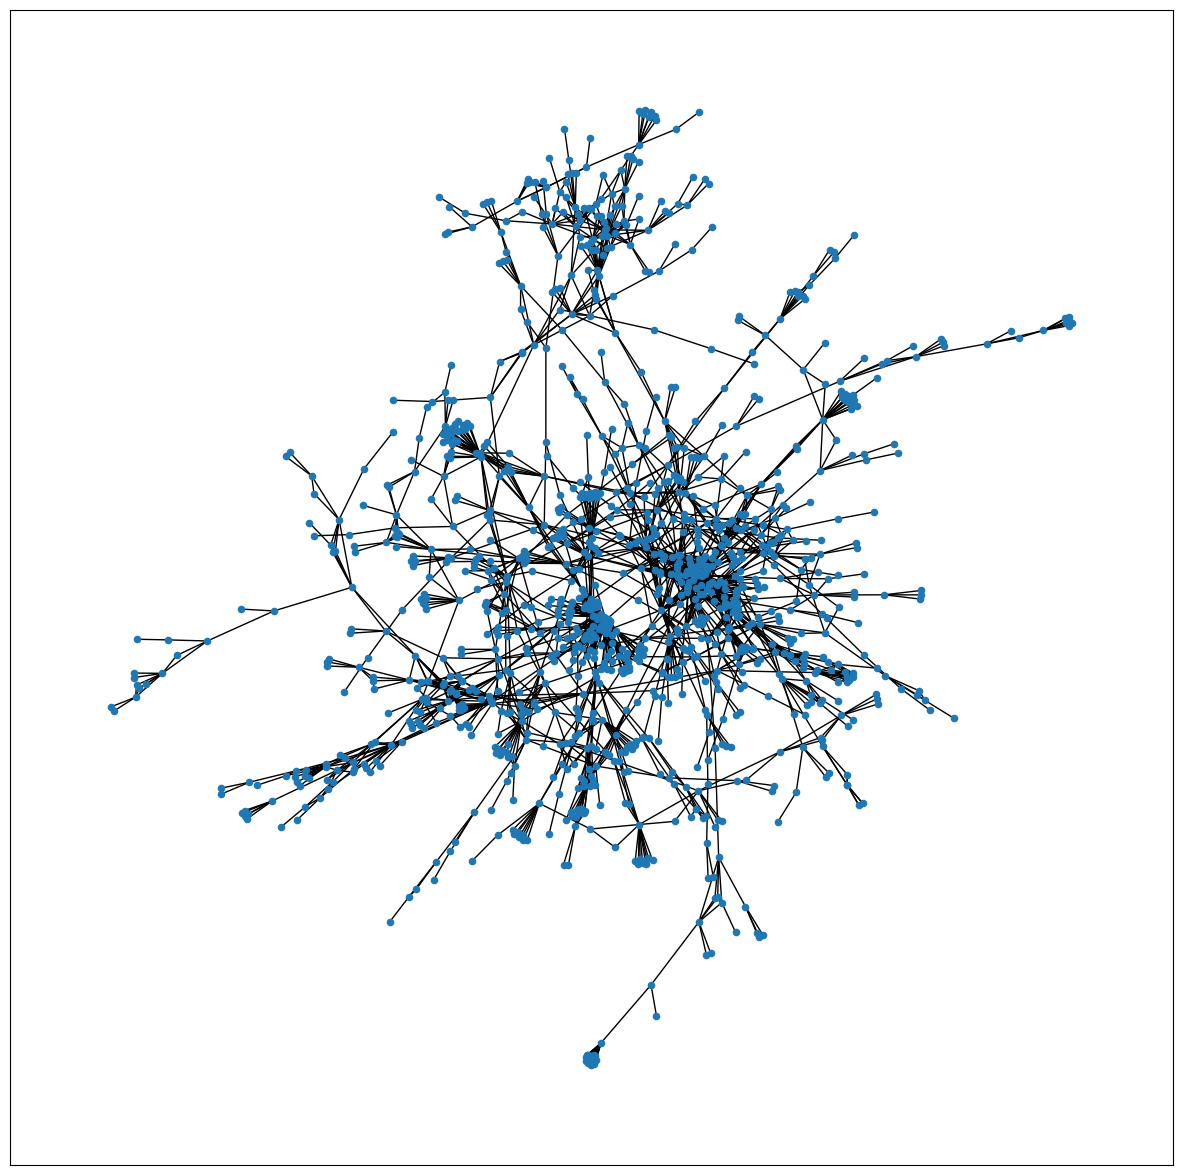

In [6]:
draw_graph(largest_cc_year[2018])

# Node regression

TODO
- Don’t use track_popularity for predicting artist popularity
- Use average of features of ALL tracks an artist was in
- New features: number of songs, node_features indep of member/initiated etc

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from karateclub import DeepWalk
import networkx as nx
class NodeRegression:
    def __init__(self) -> None:
        self.cols_for_reg = [
            "followers","num_genres", 'member_track_popularity', 'member_duration_ms', 'member_explicit', 'member_danceability', 'member_energy', 'member_key',
            'member_loudness', 'member_mode', 'member_speechiness', 'member_acousticness', 'member_instrumentalness',
            'member_liveness', 'member_valence', 'member_tempo', 'member_time_signature', "artist_popularity"
        ]

    def create_data(self, artists_600_features, nodes_600):
        artists_features_set = set(artists_600_features.index)
        edge_list_features = [tuple(l[:2]) for l in nodes_600.values.tolist() if (l[0] in artists_features_set and l[1] in artists_features_set)]
        G = ntx.from_edgelist(edge_list_features)
        lcc_features = G.subgraph(max(ntx.connected_components(G), key=len))
        df_lcc = artists_600_features.loc[list(lcc_features.nodes)]
        return lcc_features, df_lcc
    
    def get_df_reg(self, df):
        return df[self.cols_for_reg]
    
    def drop_nas(self, graph, df):
        artists_with_na = df[df.isnull().sum(axis=1) > 0].index
        graph = nx.Graph(graph)
        graph.remove_nodes_from(artists_with_na)
        df = df.dropna()
        if not nx.is_connected(graph):
            print("Warning: Graph is not connected")
        return graph, df

    def add_node_attr(self, graph, df):
        dict = df.to_dict(orient="index")
        nx.set_node_attributes(graph, dict)
        return graph

    def prepare_data_regression(self, df, test_size = 0.2):
        df = df[self.cols_for_reg].dropna()
        y = df["artist_popularity"].to_numpy()
        X = df[self.cols_for_reg].drop("artist_popularity", axis= 1).to_numpy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        return X, y, X_train, X_test, y_train, y_test
    
    def fit_evaluate_ols(X_train, X_test, y_train, y_test):
        ols = LinearRegression()
        ols.fit(X_train, y_train)
        r2 = ols.score(X_test, y_test)
        print("R2 score:", round(r2, 4))
        return ols
    
    def fit_sm_ols(self, df, test_size = 0.2):
        df_reg = df[self.cols_for_reg].dropna()
        y = df_reg["artist_popularity"]
        df_reg = df_reg.drop("artist_popularity", axis=1)
        df_train, df_test, y_train, y_test = train_test_split(df_reg, y, test_size=test_size)
        df_train = sm.add_constant(df_train)
        df_test = sm.add_constant(df_test)
        model = sm.OLS(y_train, df_train).fit()
        print(model.summary())
        return model

    def fit_DW(graph, dimensions = 16):
        dw = DeepWalk(dimensions=dimensions)
        graph_num = nx.convert_node_labels_to_integers(graph, first_label=0, ordering='sorted')
        dw.fit(graph_num)
        return dw.get_embedding()
    
    def append_DW_embeddings(graph, df, dimensions = 16):
        df_sorted = df.sort_index()
        embeddings = NodeRegression.fit_DW(graph, dimensions)
        df_embeddings = pd.DataFrame(embeddings, columns = [f"DW_{i}" for i in range(1,dimensions+1)])
        df_embeddings.index = df_sorted.index
        return pd.concat([df_sorted, df_embeddings], axis = 1)

In [8]:
node_reg = NodeRegression()
graph, df_graph = node_reg.create_data(artists_600_features, nodes_600)
print(f'The largest connected component has {len(graph.nodes)} nodes.')
print(f'The largest connected component has {len(graph.edges)} edges.')

The largest connected component has 16909 nodes.
The largest connected component has 52235 edges.


In [12]:
spotify_600

,track_id,name,track_popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_id,num_artists
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.4450,...,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3,45tIt06XoI0Iio4LBEVpls,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.1770,...,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,5LiOoJbxVSAMkBS2fUm3X2,1
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.321,0.0946,...,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,5LiOoJbxVSAMkBS2fUm3X2,1
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922-01-01,0.402,0.1580,...,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,3BiJGZsyX9sJchTqcSA7Su,1
5,0BRXJHRNGQ3W4v9frnSfhu,Ave Maria,0,178933,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922-01-01,0.227,0.2610,...,1,0.0382,0.994,0.247000,0.0977,0.0539,118.891,4,3BiJGZsyX9sJchTqcSA7Su,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,[阿YueYue],[1QLBXKM5GCpyQQSVMNZqrZ],2020-09-26,0.560,0.5180,...,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,1QLBXKM5GCpyQQSVMNZqrZ,1
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,[ROLE MODEL],[1dy5WNgIKQU6ezkpZs4y8z],2020-10-21,0.765,0.6630,...,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,1dy5WNgIKQU6ezkpZs4y8z,1
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,[FINNEAS],[37M5pPGs6V1fchFJSgCguX],2020-09-02,0.535,0.3140,...,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,37M5pPGs6V1fchFJSgCguX,1
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,58,142003,0,"[Gentle Bones, Clara Benin]","[4jGPdu95icCKVF31CcFKbS, 5ebPSE9YI5aLeZ1Z2gkqjn]",2021-03-05,0.696,0.6150,...,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4,4jGPdu95icCKVF31CcFKbS,2


In [11]:
df_graph.isna().sum()

followers                        1
genres                           0
name                             0
artist_popularity                0
num_genres                       0
solo_track_popularity         8889
solo_duration_ms              8889
solo_explicit                 8889
solo_danceability             8889
solo_energy                   8889
solo_key                      8889
solo_loudness                 8889
solo_mode                     8889
solo_speechiness              8889
solo_acousticness             8889
solo_instrumentalness         8889
solo_liveness                 8889
solo_valence                  8889
solo_tempo                    8889
solo_time_signature           8889
initiated_track_popularity    8129
initiated_duration_ms         8129
initiated_explicit            8129
initiated_danceability        8129
initiated_energy              8129
initiated_key                 8129
initiated_loudness            8129
initiated_mode                8129
initiated_speechines

In [100]:
node_reg = NodeRegression()
graph, df_graph = node_reg.create_data(artists_600_features, nodes_600)
df_reg = node_reg.get_df_reg(df_graph)
print(f"Shape df_reg:", df_reg.shape, "Number of nodes in graph:", len(graph.nodes))
graph, df_reg = node_reg.drop_nas(graph, df_reg)
print(f"Shape df_reg:", df_reg.shape, "Number of nodes in graph:", len(graph.nodes))
graph = node_reg.add_node_attr(graph, df_reg)

Shape df_reg: (16909, 18) Number of nodes in graph: 16909
Shape df_reg: (16908, 18) Number of nodes in graph: 16908


In [120]:
X, y, X_train, X_test, y_train, y_test = node_reg.prepare_data_regression(df_reg)

In [133]:
ols = NodeRegression.fit_evaluate_ols(X_train, X_test, y_train, y_test)

R2 score: 0.6259


In [119]:
node_reg.fit_sm_ols(df_dw)

                            OLS Regression Results                            
Dep. Variable:      artist_popularity   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     1430.
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        18:35:20   Log-Likelihood:                -49561.
No. Observations:               13526   AIC:                         9.916e+04
Df Residuals:                   13508   BIC:                         9.929e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

## Using DeepWalk embeddings

In [140]:
df_dw = NodeRegression.append_DW_embeddings(graph, df_reg, 2)
X, y, X_train, X_test, y_train, y_test = node_reg.prepare_data_regression(df_dw)

In [143]:
df_dw.corr()

,followers,num_genres,member_track_popularity,member_duration_ms,member_explicit,member_danceability,member_energy,member_key,member_loudness,member_mode,member_speechiness,member_acousticness,member_instrumentalness,member_liveness,member_valence,member_tempo,member_time_signature,artist_popularity,DW_1,DW_2
followers,1.000000,0.195106,0.143153,-0.014162,0.032903,0.014113,0.006264,-0.001955,0.055020,0.007509,-0.019623,-0.025946,-0.045368,0.003560,-0.008762,0.010762,0.010353,0.359764,0.012654,0.114635
num_genres,0.195106,1.000000,0.109959,-0.024626,0.045732,0.000506,-0.006446,-0.002919,0.017400,0.018751,-0.030497,-0.027594,0.011872,0.030670,-0.024426,0.019214,-0.010634,0.506633,0.019948,0.163290
member_track_popularity,0.143153,0.109959,1.000000,-0.024502,0.241800,0.261928,-0.042042,-0.001339,0.193915,-0.008962,0.120269,-0.020241,-0.366839,-0.170561,0.096110,-0.013040,0.054420,0.628010,0.113827,0.126179
member_duration_ms,-0.014162,-0.024626,-0.024502,1.000000,-0.046568,-0.075099,-0.011365,0.005684,-0.026097,0.047762,-0.025019,0.028147,0.025566,0.013913,-0.019937,-0.056428,-0.013510,-0.060416,0.006535,-0.050721
member_explicit,0.032903,0.045732,0.241800,-0.046568,1.000000,0.306791,0.039601,-0.012837,0.112948,-0.026864,0.477921,-0.137973,-0.154793,-0.071280,0.050544,-0.029214,0.088585,0.155291,0.069065,0.067878
member_danceability,0.014113,0.000506,0.261928,-0.075099,0.306791,1.000000,0.305844,0.014752,0.431271,-0.084295,0.285712,-0.393763,-0.323783,-0.190656,0.504529,-0.059266,0.210853,0.096601,0.108554,0.026343
member_energy,0.006264,-0.006446,-0.042042,-0.011365,0.039601,0.305844,1.000000,0.046662,0.764308,-0.092392,0.139267,-0.690249,-0.115300,0.183663,0.356675,0.150976,0.194135,-0.029544,0.080816,0.084627
member_key,-0.001955,-0.002919,-0.001339,0.005684,-0.012837,0.014752,0.046662,1.000000,0.034148,-0.166424,0.021876,-0.032902,-0.005870,-0.007865,0.036557,0.000172,-0.000839,-0.012275,-0.003353,0.011478
member_loudness,0.055020,0.017400,0.193915,-0.026097,0.112948,0.431271,0.764308,0.034148,1.000000,-0.061240,0.141751,-0.568594,-0.426763,0.055839,0.347268,0.118344,0.190650,0.107595,0.087592,0.097262
member_mode,0.007509,0.018751,-0.008962,0.047762,-0.026864,-0.084295,-0.092392,-0.166424,-0.061240,1.000000,-0.053253,0.088958,0.001365,0.036915,-0.029269,0.001597,-0.034767,0.006089,-0.030771,0.002817


In [141]:
node_reg.fit_sm_ols(df_dw)

                            OLS Regression Results                            
Dep. Variable:      artist_popularity   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     1417.
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        18:52:37   Log-Likelihood:                -49555.
No. Observations:               13526   AIC:                         9.915e+04
Df Residuals:                   13508   BIC:                         9.928e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

# Bin

In [76]:
cop_spot_600 = spotify_600[spotify_600.num_artists > 1].copy()
cop_spot_600.artists = cop_spot_600.artists.apply(lambda x: x[1:])
cop_spot_600 = cop_spot_600.explode('id_artists')
feature_cols = ['track_popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key',
                        'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                        'liveness', 'valence', 'tempo', 'time_signature']
# group by artist and compute mean values
member_feat_features = cop_spot_600.groupby('id_artists').agg({
    a: 'mean' for a in feature_cols
})

In [1]:
def genre_splitter(genre):
    result = genre.copy()
    result = result.str.split(" ",1)
    for i in range(len(result)):
        if (len(result[i]) > 1):
            result[i] = [result[i][1]]
    return result.str.join('')

artists_600_features["top_genre"] = artists_600_features.genres.apply(lambda x: x[0] if len(x) > 0 else "")
genre_col = artists_600_features["top_genre"]
genre = (genre_col.str.strip()).str.lower()

def extract_broad_genre(genre):
    if genre == "":
        return genre
    terms = genre.split(" ")
    if len(terms) > 1:
        return terms[-1]
    else:
        return genre

set(genre.apply(extract_broad_genre).unique()).__len__()

In [ ]:
artists_in_graph = set(largest_cc.nodes)
artists_features_list = list(artists_600_features.index)
counter = 0
artists_in_graph_with_features = []
for artist_id in artists_features_list:
    if artist_id in artists_in_graph:
        counter += 1
        artists_in_graph_with_features.append(artist_id)
print("Number of nodes in the graph for which we have features:", counter)

def get_largetcc_from_nodes(df_features: pd.DataFrame, graph: ntx.Graph, nodes_list: list):
    g = graph.subgraph(nodes_list)
    lcc = g.subgraph(max(ntx.connected_components(g), key=len))
    features = df_features.loc[list(lcc.nodes)]
    return lcc, features

Number of nodes in the graph for which we have features: 17128
